<a href="https://colab.research.google.com/github/Nazalekser/Advance-ML-How-to-win-a-data-sciende-competition-/blob/main/1_Linear_regression_with_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to Time Series! #

**Forecasting** is perhaps the most common application of machine learning in the real world. Businesses forecast product demand, governments forecast economic and population growth, meteorologists forecast the weather. The understanding of things to come is a pressing need across science, government, and industry (not to mention our personal lives!), and practitioners in these fields are increasingly applying machine learning to address this need.

Time series forecasting is a broad field with a long history. This course focuses on the application of modern machine learning methods to time series data with the goal of producing the most accurate predictions. The lessons in this course were inspired by winning solutions from past Kaggle forecasting competitions but will be applicable whenever accurate forecasts are a priority.

After finishing this course, you'll know how to:
- engineer features to model the major time series components (*trends*, *seasons*, and *cycles*),
- visualize time series with many kinds of *time series plots*,
- create forecasting *hybrids* that combine the strengths of complementary models, and
- adapt machine learning methods to a variety of forecasting tasks.

As part of the exercises, you'll get a chance to participate in our [Store Sales - Time Series Forecasting](https://www.kaggle.com/c/29781) Getting Started competition. In this competition, you're tasked with forecasting sales for *Corporación Favorita* (a large Ecuadorian-based grocery retailer) in almost 1800 product categories.

# What is a Time Series? #

The basic object of forecasting is the **time series**, which is a set of observations recorded over time. In forecasting applications, the observations are typically recorded with a regular frequency, like daily or monthly.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import pandas as pd

df = pd.read_csv(
    "/content/drive/MyDrive/Kaggle/Time Series/archive/book_sales.csv",
    index_col='Date',
    parse_dates=['Date'],
).drop('Paperback', axis=1)

df.head()

,Hardcover
Date,
2000-04-01,139
2000-04-02,128
2000-04-03,172
2000-04-04,139
2000-04-05,191


This series records the number of hardcover book sales at a retail store over 30 days. Notice that we have a single column of observations `Hardcover` with a time index `Date`.

# Linear Regression with Time Series #

For the first part of this course, we'll use the linear regression algorithm to construct forecasting models. Linear regression is widely used in practice and adapts naturally to even complex forecasting tasks.

The **linear regression** algorithm learns how to make a weighted sum from its input features. For two features, we would have:

```
target = weight_1 * feature_1 + weight_2 * feature_2 + bias
```

During training, the regression algorithm learns values for the parameters `weight_1`, `weight_2`, and `bias` that best fit the `target`. (This algorithm is often called *ordinary least squares* since it chooses values that minimize the squared error between the target and the predictions.) The weights are also called *regression coefficients* and the `bias` is also called the *intercept* because it tells you where the graph of this function crosses the y-axis.

### Time-step features

There are two kinds of features unique to time series: time-step features and lag features.

Time-step features are features we can derive directly from the time index. The most basic time-step feature is the **time dummy**, which counts off time steps in the series from beginning to end.

In [ ]:

import numpy as np

df['Time'] = np.arange(len(df.index))

df.head()

,Hardcover,Time
Date,,
2000-04-01,139,0
2000-04-02,128,1
2000-04-03,172,2
2000-04-04,139,3
2000-04-05,191,4


Linear regression with the time dummy produces the model:

```
target = weight * time + bias
```

The time dummy then lets us fit curves to time series in a *time plot*, where `Time` forms the x-axis.

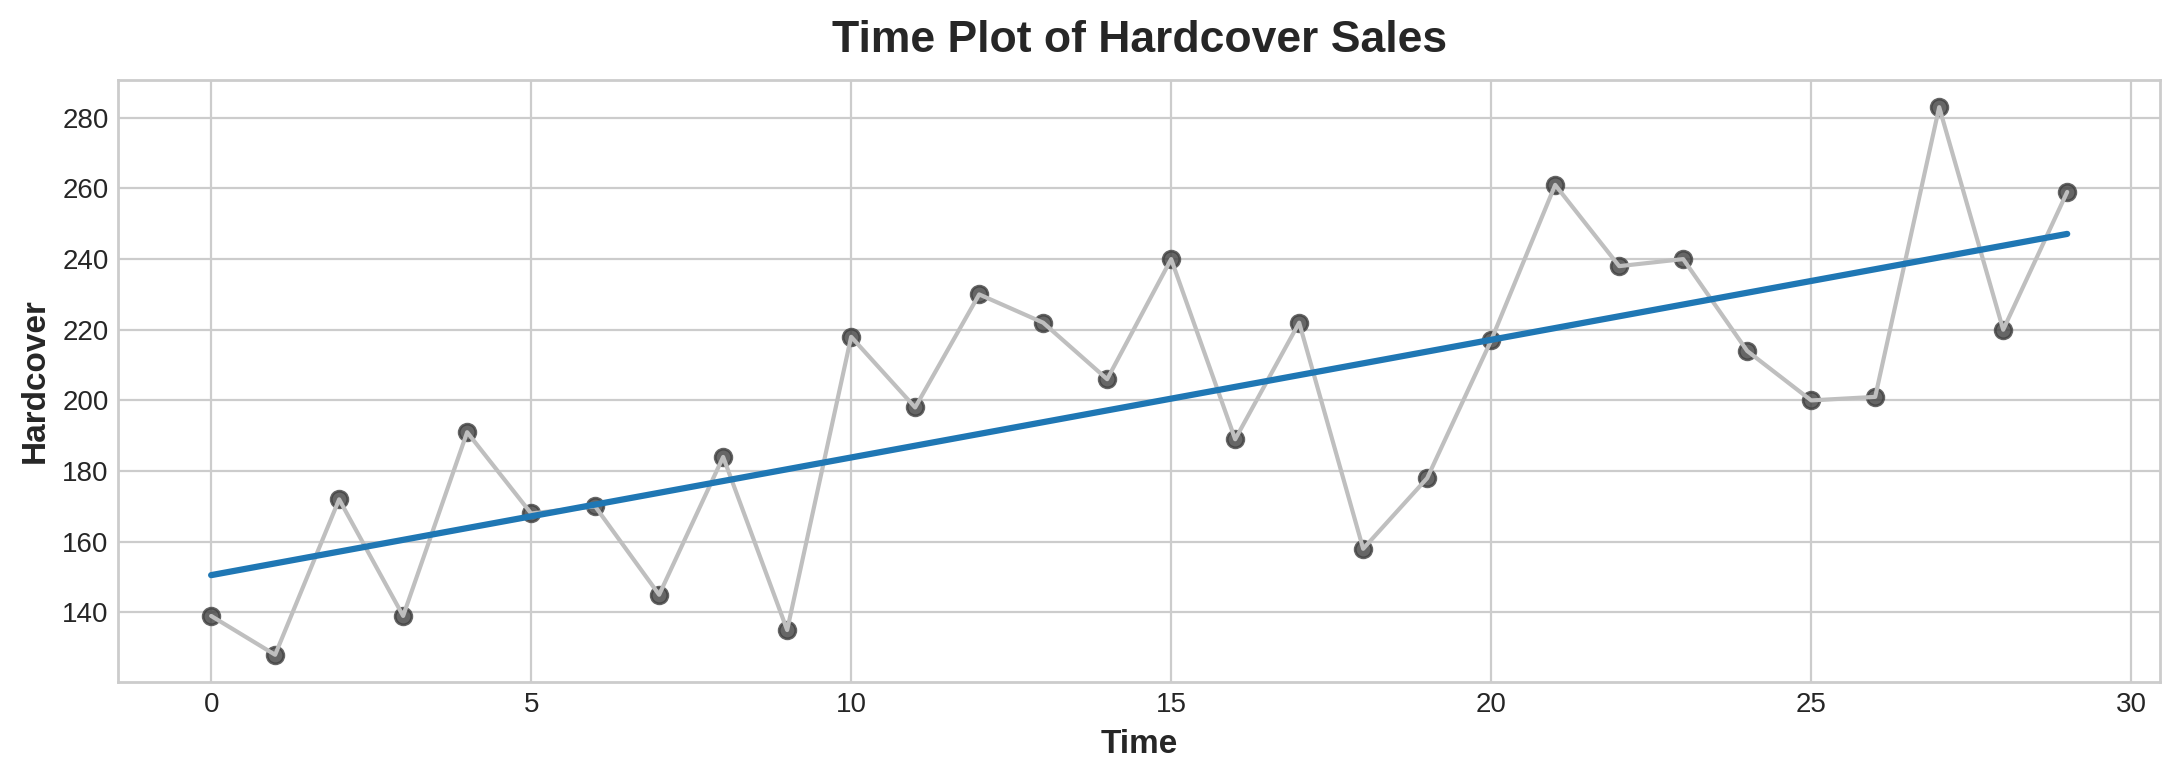

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data=df, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Hardcover Sales');

Time-step features let you model **time dependence**. A series is time dependent if its values can be predicted from the time they occured. In the *Hardcover Sales* series, we can predict that sales later in the month are generally higher than sales earlier in the month.

### Lag features

To make a **lag feature** we shift the observations of the target series so that they appear to have occured later in time. Here we've created a 1-step lag feature, though shifting by multiple steps is possible too.

In [ ]:

df['Lag_1'] = df['Hardcover'].shift(1)
df = df.reindex(columns=['Hardcover', 'Lag_1'])

df.head()

,Hardcover,Lag_1
Date,,
2000-04-01,139,NaN
2000-04-02,128,139.0
2000-04-03,172,128.0
2000-04-04,139,172.0
2000-04-05,191,139.0


Linear regression with a lag feature produces the model:

```
target = weight * lag + bias
```

So lag features let us fit curves to *lag plots* where each observation in a series is plotted against the previous observation.

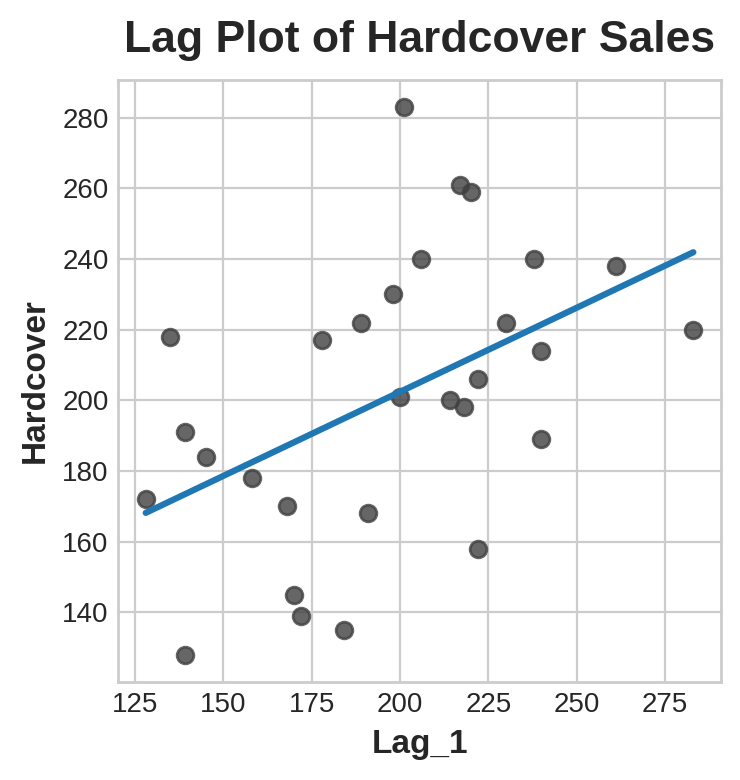

In [ ]:

fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Hardcover Sales');

You can see from the lag plot that sales on one day (`Hardcover`) are correlated with sales from the previous day (`Lag_1`). When you see a relationship like this, you know a lag feature will be useful.

More generally, lag features let you model **serial dependence**. A time series has serial dependence when an observation can be predicted from previous observations. In *Hardcover Sales*, we can predict that high sales on one day usually mean high sales the next day.

---

Adapting machine learning algorithms to time series problems is largely about feature engineering with the time index and lags. For most of the course, we use linear regression for its simplicity, but these features will be useful whichever algorithm you choose for your forecasting task.

# Example - Tunnel Traffic #

*Tunnel Traffic* is a time series describing the number of vehicles traveling through the Baregg Tunnel in Switzerland each day from November 2003 to November 2005. In this example, we'll get some practice applying linear regression to time-step features and lag features.

The hidden cell sets everything up.

In [ ]:

from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Load Tunnel Traffic dataset
# data_dir = Path("../input/ts-course-data")
tunnel = pd.read_csv("/content/drive/MyDrive/Kaggle/Time Series/archive/tunnel.csv", parse_dates=["Day"])

# Create a time series in Pandas by setting the index to a date
# column. We parsed "Day" as a date type by using `parse_dates` when
# loading the data.
tunnel = tunnel.set_index("Day")

# By default, Pandas creates a `DatetimeIndex` with dtype `Timestamp`
# (equivalent to `np.datetime64`, representing a time series as a
# sequence of measurements taken at single moments. A `PeriodIndex`,
# on the other hand, represents a time series as a sequence of
# quantities accumulated over periods of time. Periods are often
# easier to work with, so that's what we'll use in this course.
tunnel = tunnel.to_period()

tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


### Time-step feature

Provided the time series doesn't have any missing dates, we can create a time dummy by counting out the length of the series.

In [ ]:
df = tunnel.copy()

df['Time'] = np.arange(len(tunnel.index))

df.head()

,NumVehicles,Time
Day,,
2003-11-01,103536,0
2003-11-02,92051,1
2003-11-03,100795,2
2003-11-04,102352,3
2003-11-05,106569,4


The procedure for fitting a linear regression model follows the standard steps for scikit-learn.

In [ ]:
from sklearn.linear_model import LinearRegression

# Training data
X = df.loc[:, ['Time']]  # features
y = df.loc[:, 'NumVehicles']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

The model actually created is (approximately): `Vehicles = 22.5 * Time + 98176`. Plotting the fitted values over time shows us how fitting linear regression to the time dummy creates the trend line defined by this equation.

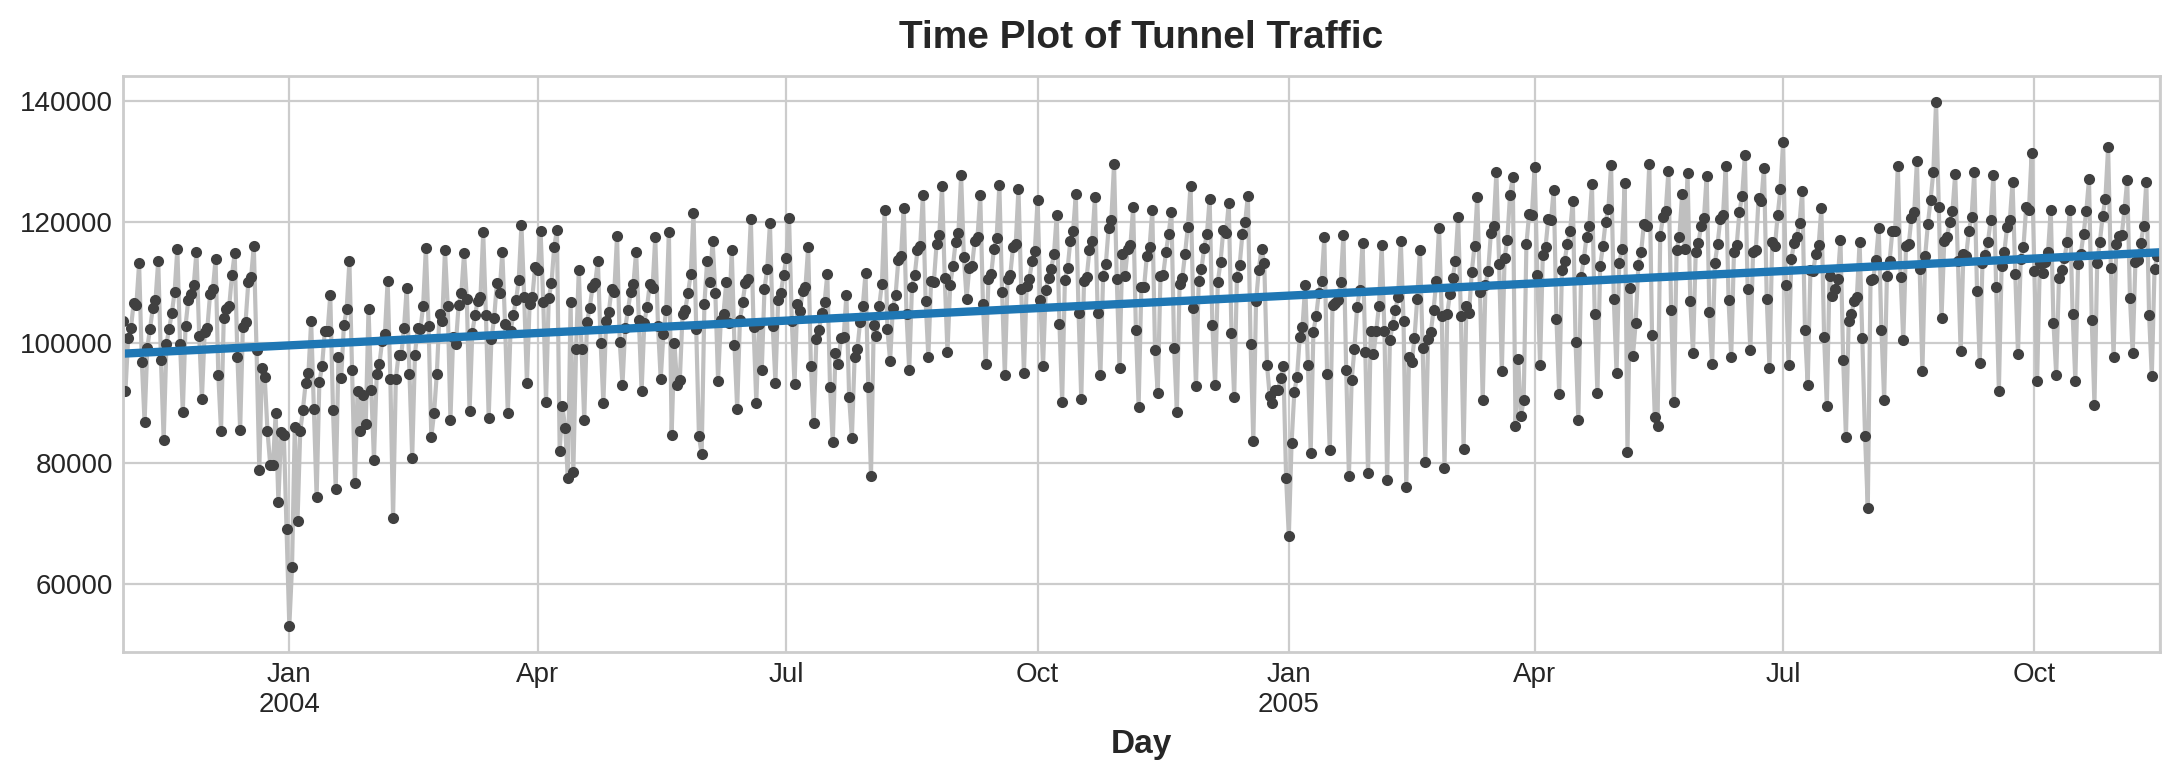

In [ ]:

ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Tunnel Traffic');

### Lag feature

Pandas provides us a simple method to lag a series, the `shift` method.

In [ ]:
df['Lag_1'] = df['NumVehicles'].shift(1)
df.head()

,NumVehicles,Time,Lag_1
Day,,,
2003-11-01,103536,0,NaN
2003-11-02,92051,1,103536.0
2003-11-03,100795,2,92051.0
2003-11-04,102352,3,100795.0
2003-11-05,106569,4,102352.0


When creating lag features, we need to decide what to do with the missing values produced. Filling them in is one option, maybe with 0.0 or "backfilling" with the first known value. Instead, we'll just drop the missing values, making sure to also drop values in the target from corresponding dates.

In [ ]:
from sklearn.linear_model import LinearRegression

X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'NumVehicles']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

The lag plot shows us how well we were able to fit the relationship between the number of vehicles one day and the number the previous day.

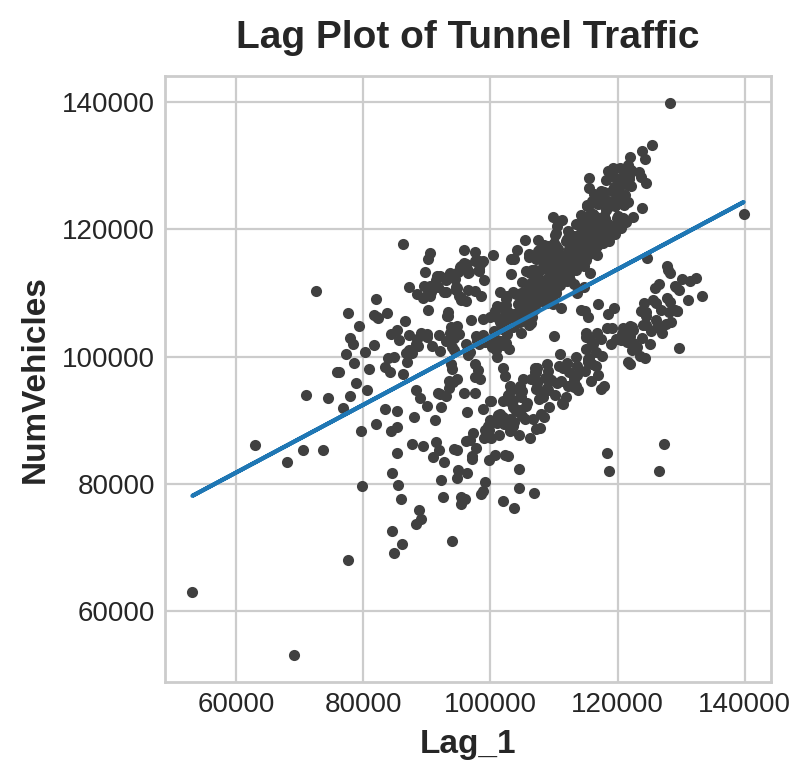

In [ ]:

fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Tunnel Traffic');

What does this prediction from a lag feature mean about how well we can predict the series across time? The following time plot shows us how our forecasts now respond to the behavior of the series in the recent past.

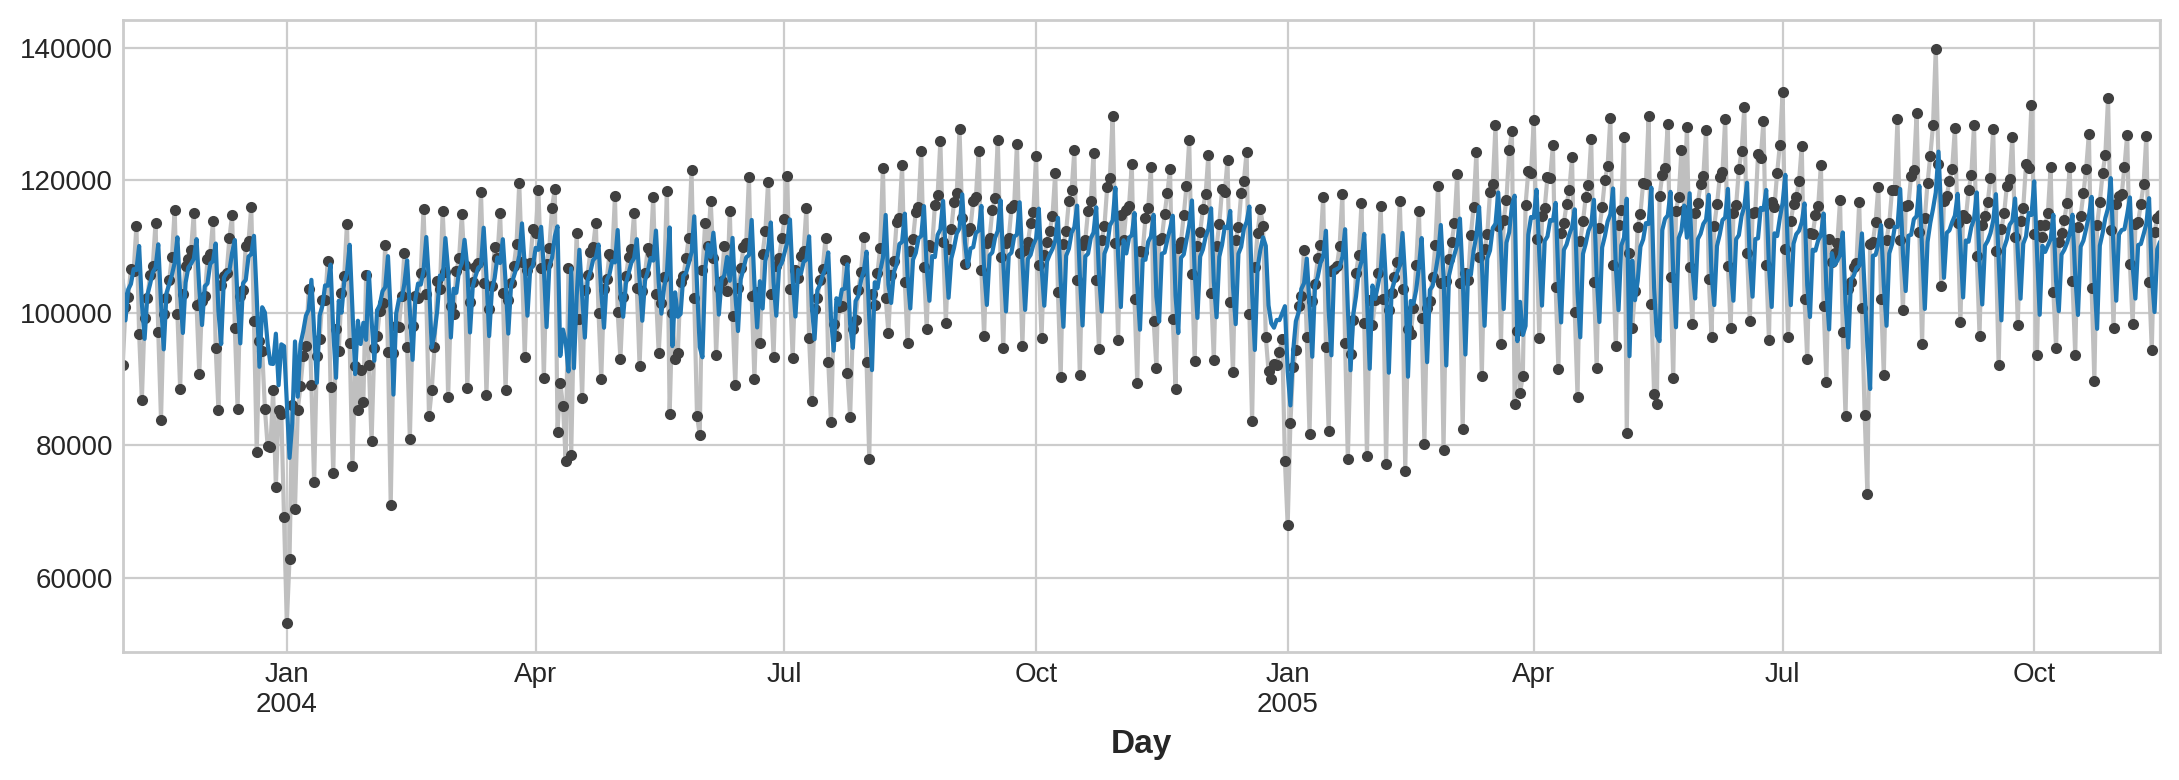

In [ ]:

ax = y.plot(**plot_params)
ax = y_pred.plot()

The best time series models will usually include some combination of time-step features and lag features. Over the next few lessons, we'll learn how to engineer features modeling the most common patterns in time series using the features from this lesson as a starting point.

# Your Turn #

Move on to the Exercise, where you'll begin [**forecasting Store Sales**](https://www.kaggle.com/kernels/fork/19615998) using the techniques you learned in this tutorial.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/time-series/discussion) to chat with other learners.*